In [25]:
import yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from functools import lru_cache

In [28]:
def ytd() -> int:
    return (pd.Timestamp.now() - pd.Timestamp(str(pd.Timestamp.now().year) + '-01-01')).days

@lru_cache
def get_ticker_data(ticker: str, start_date: str = '1920-01-01', end_date: str = '2022-01-01', period='1d', days_ago: int = None):
    ticker_data = yfinance.Ticker(ticker)
    ticker_data = ticker_data.history(period='1d', start=start_date, end=end_date)
    if days_ago is not None: # slice again to days ago argument if needed 
        days_ago = days_ago if days_ago > 0 else ytd()
        ticker_data = ticker_data[pd.Timestamp.now() - pd.Timedelta(days=days_ago):]
    if len(ticker_data) == 0:
        raise Exception(f'no data for: {ticker}')
    return ticker_data[['Close']]


def compare_securities(tickers: list[str], normalize_prices=True, days_ago: int = None):
    # populate raw data
    raw_data = dict()
    for ticker in tickers:
        raw_data[ticker] = get_ticker_data(ticker)
    
    # align all data to same time range
    min_dates = []
    max_dates = []
    for df in raw_data.values():
        min_dates.append(df.index.min())
        max_dates.append(df.index.max())
    max_min = np.array(min_dates)[np.argmax(np.array(min_dates))]
    min_max = np.array(max_dates)[np.argmin(np.array(max_dates))]
    
    for ticker, data in raw_data.items():
        data = data[max_min:min_max] # slice data in time range
        if days_ago is not None: # slice again to days ago argument if needed 
            days_ago = days_ago if days_ago > 0 else ytd()
            data = data[pd.Timestamp.now() - pd.Timedelta(days=days_ago):]
        
        # normalized prices so that comparison plot makes intuitive sense (current_price / begining price)
        first_value = data['Close'].iloc[0].copy()
        ticker_df = pd.DataFrame()
        ticker_df['price'] = data['Close'].apply(lambda x: x / first_value) \
            if normalize_prices else data['Close']
        
        print(f'performance for "{ticker}": {(ticker_df.values[-1][0] / ticker_df.values[0][0]):.2f}X')
        plt.plot(ticker_df, label=ticker)
        
        # sns.lineplot(x=ticker_df.index, y=ticker_df.values)
    plt.legend()
    plt.xticks(rotation=45, ha='right')
    plt.show()

performance for "SPY": 4.57X
performance for "VNQ": 2.99X
performance for "SCHH": 2.54X


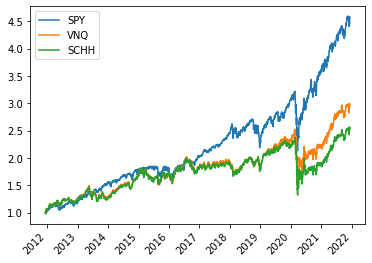

In [36]:
compare_securities(['SPY', 'VNQ', 'SCHH'], days_ago=365*10) # VNQ Vanguard real-estate, SCHH	Schwab US REIT ETF